<a href="https://colab.research.google.com/github/NarenChittem/MBBResearch/blob/main/FinalMBBKaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

!pip install -q -U watermark

!pip install -qq transformers

!pip install pyspellchecker

%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Wed May 17 22:48:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -qq transformers

In [3]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.10.11
IPython version      : 7.34.0

numpy       : 1.22.4
pandas      : 1.5.3
torch       : 2.0.0+cu118
transformers: 4.29.2



## Data Exploration and Preprocessing

[link text](https://)

In [4]:
import os
import pandas as pd

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# File path of the CSV files
csv_folder = '/content/drive/MyDrive/archive/'

# Read data from the uploaded dataset files
processed_positive_df = pd.read_csv(os.path.join(csv_folder, 'processedPositive.csv'), header=None)
processed_negative_df = pd.read_csv(os.path.join(csv_folder, 'processedNegative.csv'), header=None)
processed_neutral_df = pd.read_csv(os.path.join(csv_folder, 'processedNeutral.csv'), header=None)

# Reshape the dataframes
processed_positive_df = processed_positive_df.transpose().dropna()
processed_negative_df = processed_negative_df.transpose().dropna()
processed_neutral_df = processed_neutral_df.transpose().dropna()

# Add labels to the dataframes
processed_positive_df['labels'] = 2
processed_negative_df['labels'] = 1
processed_neutral_df['labels'] = 0

# Concatenate the dataframes
df = pd.concat([processed_positive_df, processed_negative_df, processed_neutral_df], ignore_index=True)
df.columns = ['tweet_text', 'labels']  # Assign column names


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df.head()

,tweet_text,labels
0,An inspiration in all aspects: Fashion,2
1,fitness,2
2,beauty and personality. :)KISSES TheFashionIcon,2
3,Apka Apna Awam Ka Channel Frankline Tv Aam Adm...,2
4,Beautiful album from the greatest unsung guit...,2


In [6]:
label_counts = df['labels'].value_counts()
print(label_counts)

0    1569
2    1183
1    1116
Name: labels, dtype: int64


## Data Preprocessing



In [7]:
import torch
from transformers import BertModel, BertTokenizer

# Set the pre-trained model name
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

# Create an instance of the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

# Create an instance of the BERT model
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
MAX_LEN = 240

In [9]:
from torch.utils.data import Dataset

class TwitterDataset(Dataset):
    def __init__(self, tweets, labels, tokenizer, max_len):
        self.tweets = tweets
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, item):
        tweet = str(self.tweets[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True, 
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'tweet_text': tweet,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [10]:
from sklearn.model_selection import train_test_split
import random

RANDOM_SEED = random.randint(1, 1000)
df_train, df_test = train_test_split(df, test_size=0.3, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.3, random_state=RANDOM_SEED)

In [11]:
df_train.shape, df_val.shape, df_test.shape

((2707, 2), (812, 2), (349, 2))

In [12]:
from torch.utils.data import DataLoader

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = TwitterDataset(
      tweets=df.tweet_text.to_numpy(),
      labels=df.labels.to_numpy(),
      tokenizer=tokenizer,
      max_len=max_len
  )

  return DataLoader(
      ds,
      batch_size=batch_size,
      num_workers=4
  )


In [13]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


In [14]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'labels'])

In [15]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

torch.Size([16, 240])
torch.Size([16, 240])
torch.Size([16])


## Sentiment Classification with BERT and Hugging Face

In [16]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
import torch.nn as nn

class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    outputs = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask
    )
    pooled_output = outputs.pooler_output
    output = self.drop(pooled_output)
    return self.out(output)


In [18]:
import torch
import torch.nn as nn
from transformers import BertModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_names = ['positive', 'negative', 'neutral']
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 240])
torch.Size([16, 240])


In [20]:
import torch.nn.functional as F

F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.3652, 0.1820, 0.4529],
        [0.3450, 0.2961, 0.3589],
        [0.3857, 0.2327, 0.3815],
        [0.2352, 0.1524, 0.6125],
        [0.4680, 0.2036, 0.3284],
        [0.3288, 0.3293, 0.3419],
        [0.2375, 0.2493, 0.5133],
        [0.2068, 0.3831, 0.4102],
        [0.3935, 0.2091, 0.3974],
        [0.2847, 0.2441, 0.4712],
        [0.3578, 0.2160, 0.4261],
        [0.3738, 0.2603, 0.3659],
        [0.2545, 0.1921, 0.5534],
        [0.1700, 0.3596, 0.4704],
        [0.2263, 0.2579, 0.5158],
        [0.3441, 0.2673, 0.3885]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

### Training

In [21]:
import torch.optim as optim
from transformers import get_linear_schedule_with_warmup
import torch.nn as nn

EPOCHS = 10

optimizer = optim.AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [22]:
import torch
import numpy as np
import torch.nn as nn

def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["labels"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets.flatten()) # Updated: Flatten targets - reverse if it is not working

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [23]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [24]:
from collections import defaultdict
import torch
import numpy as np
from tqdm import tqdm
import time

start_time = time.time()

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.522198050096631 accuracy 0.7728112301440709
Val   loss 0.23322381320245125 accuracy 0.9236453201970444

Epoch 2/10
----------
Train loss 0.1760069050880916 accuracy 0.9471739933505726
Val   loss 0.27127450007908777 accuracy 0.9310344827586207

Epoch 3/10
----------
Train loss 0.08921546635272748 accuracy 0.9737717029922424
Val   loss 0.3086355556368682 accuracy 0.9347290640394089

Epoch 4/10
----------
Train loss 0.042248975706409994 accuracy 0.9881787957148135
Val   loss 0.31720623252434 accuracy 0.9433497536945813

Epoch 5/10
----------
Train loss 0.017920208562110716 accuracy 0.995567048393055
Val   loss 0.3445962029243888 accuracy 0.9396551724137931

Epoch 6/10
----------
Train loss 0.015322718336863224 accuracy 0.9966752862947913
Val   loss 0.37842358907287504 accuracy 0.937192118226601

Epoch 7/10
----------
Train loss 0.006388899381015696 accuracy 0.9981529368304396
Val   loss 0.3864737563250374 accuracy 0.9359605911330049

Epoch 8/10
---------

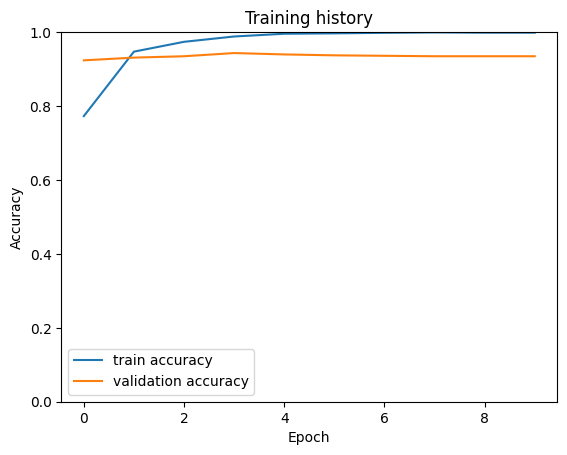

In [25]:
import matplotlib.pyplot as plt
import numpy as np

train_acc = [acc.cpu().numpy() for acc in history['train_acc']]
val_acc = [acc.cpu().numpy() for acc in history['val_acc']]

plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

plt.show()


## Evaluation

In [26]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.9369627507163324

In [27]:
import os

# Define the file path for saving the model
save_path = "./mbb.pth"
torch.save(model.state_dict(), save_path)

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentClassifier(len(class_names))
model = model.to(device)

load_path = "./mbb.pth"
model.load_state_dict(torch.load(load_path, map_location=device))

model.eval()



test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

test_data = next(iter(test_data_loader))
test_data = {key: val.to(device) for key, val in test_data.items() if key != 'tweet_text'}


test_acc, test_loss = eval_model(model, test_data_loader, loss_fn, device, len(df_test))
print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Test loss: 0.38543593794152414, Test accuracy: 0.9369627507163324


In [29]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  twitter_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      twitter_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return twitter_texts, predictions, prediction_probs, real_values

In [30]:
y_twitter_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [31]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    positive       0.96      0.98      0.97       136
    negative       0.92      0.89      0.90       101
     neutral       0.92      0.93      0.92       112

    accuracy                           0.94       349
   macro avg       0.93      0.93      0.93       349
weighted avg       0.94      0.94      0.94       349



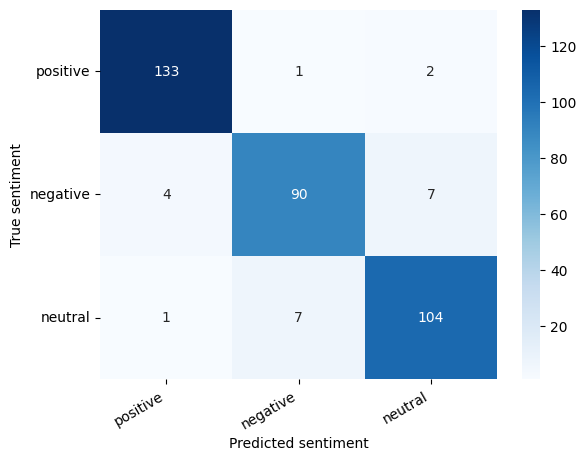

In [32]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

## Application of the Model: Charlottesville







In [70]:
import os
import pandas as pd

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# File path of the CSV files
csv_folder = '/content/drive/MyDrive/archive/'

# Read data from the "aug15_sample.csv" files and include only the "full_text" column
df1 = pd.read_csv(os.path.join(csv_folder, 'aug15_sample.csv'), usecols=['full_text'])
df2 = pd.read_csv(os.path.join(csv_folder, 'aug16_sample.csv'), usecols=['full_text'])
df3 = pd.read_csv(os.path.join(csv_folder, 'aug17_sample.csv'), usecols=['full_text'])

# Concatenate the dataframes
dfc = pd.concat([df1, df2, df3], ignore_index=True)
dfc.columns = ['tweet_text']  # Assign column name

# Display the combined dataframe
print(dfc.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                                          tweet_text
0  I'm white and I won't go anywhere near Alabama...
1  Another chief leaves Trump's manufacturing cou...
2  @SenWarren No he didn't #fauxcohontas! He cond...
3  https://t.co/zA33WQp977 #News Histórico líder ...
4  "@DavidEMcK59 @cathymdonker @southoflife75 @Su...


In [71]:
import torch
from transformers import BertModel, BertTokenizer

# Set the pre-trained model name
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

# Create an instance of the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

# Create an instance of the BERT model
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_path = "./mbb.pth"

# Create an instance of the SentimentClassifier model
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = bert_model
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs.pooler_output
        output = self.drop(pooled_output)
        return self.out(output)

# Create an instance of the SentimentClassifier model
model = SentimentClassifier(len(class_names))
model = model.to(device)

# Load the saved model state dict
model.load_state_dict(torch.load(load_path, map_location=device))


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [73]:
from torch.utils.data import DataLoader

MAX_LEN = 240

BATCH_SIZE = 16

In [74]:
from torch.utils.data import Dataset, Subset, DataLoader

class CharlottesvilleDataset(Dataset):
    def __init__(self, tweets, tokenizer, max_len, subset=None):
        self.tweets = tweets
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.subset = subset

        if self.subset is not None:
            self.tweets = self.tweets[self.subset]

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, item):
        tweet = str(self.tweets[item])

        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'tweet_text': tweet,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }


In [81]:
def create_data_loader(tweets, tokenizer, max_len, batch_size, subset_size=None):
    if subset_size is not None:
        random.seed(42)  # Set a random seed for reproducibility
        indices = list(range(len(tweets)))
        subset_indices = random.sample(indices, subset_size)
        tweets = tweets[subset_indices]

    ds = CharlottesvilleDataset(
        tweets=tweets,
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )


In [90]:
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the data loader for the CharlottesvilleDataset
data_loader = create_data_loader(dfc.tweet_text.to_numpy(), tokenizer, MAX_LEN, BATCH_SIZE, subset_size=None)

# Set the model to evaluation mode
model.eval()

# Initialize counts for neutral, positive, and negative tweets
neutral_count = 0
positive_count = 0
negative_count = 0

# Iterate over the data loader and perform inference
for batch in data_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        logits = outputs[0]

    # Calculate predicted labels
    predicted_labels = torch.argmax(logits, dim=-1)

    # Update the counts within each batch
    neutral_count += (predicted_labels == 0).sum().item()
    negative_count += (predicted_labels == 1).sum().item()
    positive_count += (predicted_labels == 2).sum().item()

# Print the total counts
print("Neutral count (total):", neutral_count)
print("Negative count (total):", negative_count)
print("Positive count (total):", positive_count)


Neutral count (total): 786
Negative count (total): 350
Positive count (total): 8239


## Application of the Model: 2020 Presidential Election







In [135]:
import os
import pandas as pd

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# File path of the CSV files
csv_folder = '/content/drive/MyDrive/archive/'

# Read data from the "hashtag_donaldtrump.csv" file and include only the "tweet" column
df1 = pd.read_csv(os.path.join(csv_folder, 'hashtag_donaldtrump.csv'), lineterminator='\n')
df1 = df1[['tweet']].rename(columns={'tweet': 'tweet_text'})

# Read data from the "hashtag_joebiden.csv" file and include only the "tweet" column
df2 = pd.read_csv(os.path.join(csv_folder, 'hashtag_joebiden.csv'), lineterminator='\n')
df2 = df2[['tweet']].rename(columns={'tweet': 'tweet_text'})



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [136]:
import torch
from transformers import BertModel, BertTokenizer

# Set the pre-trained model name
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

# Create an instance of the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

# Create an instance of the BERT model
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_path = "./mbb.pth"

# Create an instance of the SentimentClassifier model
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = bert_model
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs.pooler_output
        output = self.drop(pooled_output)
        return self.out(output)

# Create an instance of the SentimentClassifier model
model = SentimentClassifier(len(class_names))
model = model.to(device)

# Load the saved model state dict
model.load_state_dict(torch.load(load_path, map_location=device))


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [138]:
from torch.utils.data import DataLoader

MAX_LEN = 240

BATCH_SIZE = 16

In [140]:
from torch.utils.data import Dataset

class PresidentDataset(Dataset):
    def __init__(self, tweets, tokenizer, max_len, subset=None):
        self.tweets = tweets
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.subset = subset

        if self.subset is not None:
            self.tweets = self.tweets[self.subset]

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, item):
        tweet = str(self.tweets[item])

        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'tweet_text': tweet,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }


In [144]:
from torch.utils.data import DataLoader

def create_data_loader(tweets, tokenizer, max_len, batch_size, subset_size=None):
    if subset_size is not None:
        random.seed(42)  # Set a random seed for reproducibility
        indices = list(range(len(tweets)))
        subset_indices = random.sample(indices, subset_size)
        tweets = tweets[subset_indices]

    ds = PresidentDataset(
        tweets=tweets,
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )


In [146]:
#Trump Hashtag
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the data loader for the CharlottesvilleDataset
data_loader = create_data_loader(df1.tweet_text.to_numpy(), tokenizer, MAX_LEN, BATCH_SIZE, subset_size=100000)

# Set the model to evaluation mode
model.eval()

# Initialize counts for neutral, positive, and negative tweets
neutral_count = 0
positive_count = 0
negative_count = 0

# Iterate over the data loader and perform inference
for batch in data_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        logits = outputs[0]

    # Calculate predicted labels
    predicted_labels = torch.argmax(logits, dim=-1)

    # Update the counts within each batch
    neutral_count += (predicted_labels == 0).sum().item()
    negative_count += (predicted_labels == 1).sum().item()
    positive_count += (predicted_labels == 2).sum().item()

# Print the total counts
print("Neutral count (total):", neutral_count)
print("Negative count (total):", negative_count)
print("Positive count (total):", positive_count)


Neutral count (total): 510
Negative count (total): 250
Positive count (total): 5490


In [147]:
#Biden Hashtag

import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the data loader for the CharlottesvilleDataset
data_loader = create_data_loader(df2.tweet_text.to_numpy(), tokenizer, MAX_LEN, BATCH_SIZE, subset_size=100000)

# Set the model to evaluation mode
model.eval()

# Initialize counts for neutral, positive, and negative tweets
neutral_count = 0
positive_count = 0
negative_count = 0

# Iterate over the data loader and perform inference
for batch in data_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        logits = outputs[0]

    # Calculate predicted labels
    predicted_labels = torch.argmax(logits, dim=-1)

    # Update the counts within each batch
    neutral_count += (predicted_labels == 0).sum().item()
    negative_count += (predicted_labels == 1).sum().item()
    positive_count += (predicted_labels == 2).sum().item()

# Print the total counts
print("Neutral count (total):", neutral_count)
print("Negative count (total):", negative_count)
print("Positive count (total):", positive_count)


Neutral count (total): 532
Negative count (total): 183
Positive count (total): 5535
